In [23]:
# ====== Packages =======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from tqdm import tqdm

# ---- data manipulators ----
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample

# ---- algorithms ----
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# ---- evaluation ------
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, RocCurveDisplay, roc_curve, precision_recall_curve

# ---- user defined modules ----
import pre_proccessing_helpers as hel
import models_helpers as mh


# This line makes matplotlib plot the figures inside the norebook
%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10

## Taking a look at the pre-processed dataset

In [24]:
dataset = pd.read_csv("data/preprocessed_data.csv")
dataset

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,COVID,ICU,DIED
0,0,0,1,1,0,1,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
1,0,0,0,1,0,1,1,0,0,0,...,0,1,0,0,1,1,0,0,0,1
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
3,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019661,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1019662,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1019663,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1019664,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the data

In [25]:
X_train, y_train, X_test, y_test = mh.data_split(dataset ,n_splits=1, test_size=0.2, train_size=0.8)

data_test = pd.concat([X_test, y_test], axis=1)
X_test, y_test, X_val, y_val = mh.data_split(data_test , n_splits=1, test_size=0.5, train_size=0.5)

## Xgboost Classifier:

### Hyperparameters optimization with GridSearchCV:
* Note: we will do 2 rounds of optimization to speed up the search.

In [26]:
# Round1:
params1 = {
           'max_depth': [3, 4, 5],
           'learning_rate': [0.1, 0.01, 0.05],
           'gamma': [0, 0.25, 1.0],
           'reg_lambda': [0, 1.0, 10.0],
           'scale_pos_weight': [1, 3, 5]
         }


#Round2:
params2 = {
           'max_depth': [5, 6, 7],
           'learning_rate': [0.1, 0.12, 0.08],
          }

optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', early_stopping_rounds=10, subsample=0.8),
                              param_grid=params2,
                              scoring='roc_auc',
                              verbose=1,
                              n_jobs=10,
                              cv=3
                             )

### GridSearchCV results:
* round 1: gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=3 (max_score=0.96)
* round 2: gamma=0.25, learning_rate=0.12, max_depth=5, reg_lambda=10.0, scale_pos_weight=3 (max_score=0.96)

In [27]:
optimal_params.fit(X_train, y_train,verbose=0, eval_set=[(X_val, y_val)])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=Non

In [28]:
print(f"best parameters: {optimal_params.best_params_}")

best parameters: {'learning_rate': 0.12, 'max_depth': 6}


## Run the Xgboost with the optimized hyperparameters:

+--------------+--------------------+
|    Metric    |       Score        |
+--------------+--------------------+
|   accuracy   | 0.9311934253238793 |
|    recall    | 0.7964806984040377 |
|  presicion   | 0.5138607762034674 |
|   f1 score   | 0.6246924146785064 |
| f_beta score | 0.7175510605353063 |
+--------------+--------------------+


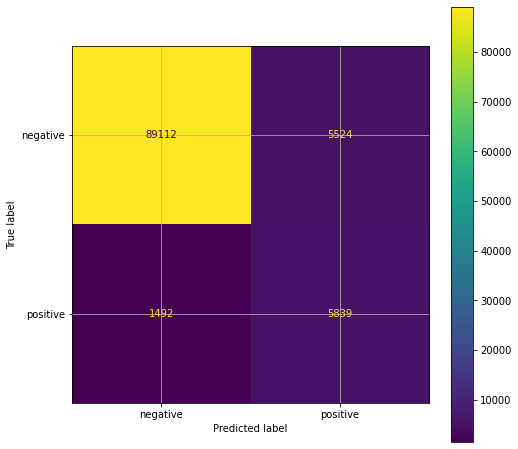

In [30]:
xgb_post_val = xgb.XGBClassifier(objective='binary:logistic',  eval_metric='aucpr', early_stopping_rounds=10, learning_rate=0.12, max_depth=5, reg_lambda=10.0, gamma=0.25, scale_pos_weight=3)
xgb_post_val.fit(X_train, y_train,verbose=False, eval_set=[(X_val, y_val)])
xgb_post_val_pred = xgb_post_val.predict(X_test)

mh.model_evaluation(y_test, xgb_post_val_pred)